***

This notebook contains the code samples found in Chapter 6, Section 3 of "Deep Learning with R"

***

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We will cover the following techniques:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).
* *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

Let's take a look at the data. We will be installing a few required packages & doing a one time authentication of google drive to download the dataset.

In [1]:
install.packages('googledrive') 
install.packages('httpuv') 
library(googledrive) 
library(httpuv)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘promises’, ‘later’




In [2]:
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { #may update python version  
                                       #occasionally
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




We need to authenticate a connection to the course google drive that contains the file once.

After running the below script:

1) Click on the link that appears at the bottom   
2) Select the google account associated with this Colab session (The account displayed in colab at the top right!)   
3) Check all tickboxes to give R permission to download images from the drive    
4) Copy the code displayed & paste it here at the field shown & press enter

In [3]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWj0AkzkmTiD0gO5ZJBrmVtsCy8Au2NNOtEqX6GR5s4bv0TWe_Wl1Xc


Dowloading the required file 'jena_climate_2009_2016' from drive to Colab local

In [8]:
file_id <- drive_ls("~/AI_Datasets/",recursive = T,pattern = "jena",type = "csv")
x <- drive_get(as_id(file_id))
drive_download(x)























File downloaded:

• jena_climate_2009_2016.csv <id: 1XYcl6SygwYdmMBPOKd2n_zT785f6CPeN>

Saved locally as:

• jena_climate_2009_2016.csv



Reading and looking at the data

In [9]:
library(tibble)
library(readr)

fname <- file.path("jena_climate_2009_2016.csv")
data <- read_csv(fname)

Rows: 420451 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Date Time
dbl (14): p (mbar), T (degC), Tpot (K), Tdew (degC), rh (%), VPmax (mbar), V...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
glimpse(data)

Rows: 420,451
Columns: 15
$ `Date Time`       <chr> "01.01.2009 00:10:00", "01.01.2009 00:20:00", "01.01…
$ `p (mbar)`        <dbl> 996.52, 996.57, 996.53, 996.51, 996.51, 996.50, 996.…
$ `T (degC)`        <dbl> -8.02, -8.41, -8.51, -8.31, -8.27, -8.05, -7.62, -7.…
$ `Tpot (K)`        <dbl> 265.40, 265.01, 264.91, 265.12, 265.15, 265.38, 265.…
$ `Tdew (degC)`     <dbl> -8.90, -9.28, -9.31, -9.07, -9.04, -8.78, -8.30, -8.…
$ `rh (%)`          <dbl> 93.3, 93.4, 93.9, 94.2, 94.1, 94.4, 94.8, 94.4, 93.8…
$ `VPmax (mbar)`    <dbl> 3.33, 3.23, 3.21, 3.26, 3.27, 3.33, 3.44, 3.44, 3.36…
$ `VPact (mbar)`    <dbl> 3.11, 3.02, 3.01, 3.07, 3.08, 3.14, 3.26, 3.25, 3.15…
$ `VPdef (mbar)`    <dbl> 0.22, 0.21, 0.20, 0.19, 0.19, 0.19, 0.18, 0.19, 0.21…
$ `sh (g/kg)`       <dbl> 1.94, 1.89, 1.88, 1.92, 1.92, 1.96, 2.04, 2.03, 1.97…
$ `H2OC (mmol/mol)` <dbl> 3.12, 3.03, 3.02, 3.08, 3.09, 3.15, 3.27, 3.26, 3.16…
$ `rho (g/m**3)`    <dbl> 1307.75, 1309.80, 1310.24, 1309.19, 1309.00, 1307.86…
$ `wv (m/s)`  

Here is the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature.

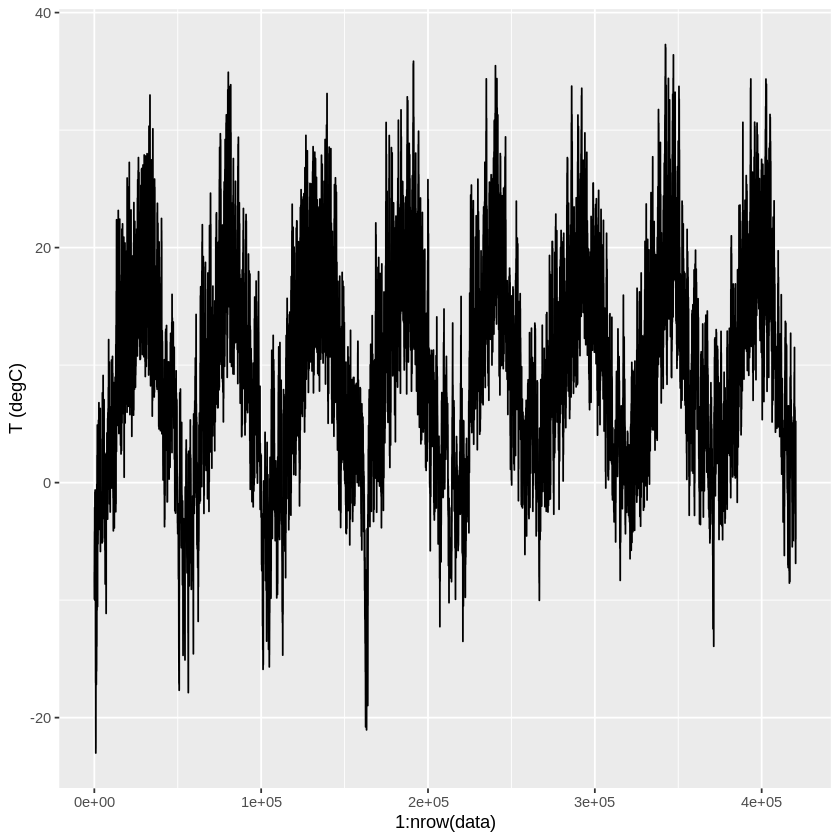

In [11]:
library(ggplot2)
ggplot(data, aes(x = 1:nrow(data), y = `T (degC)`)) + geom_line()

On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points per day):

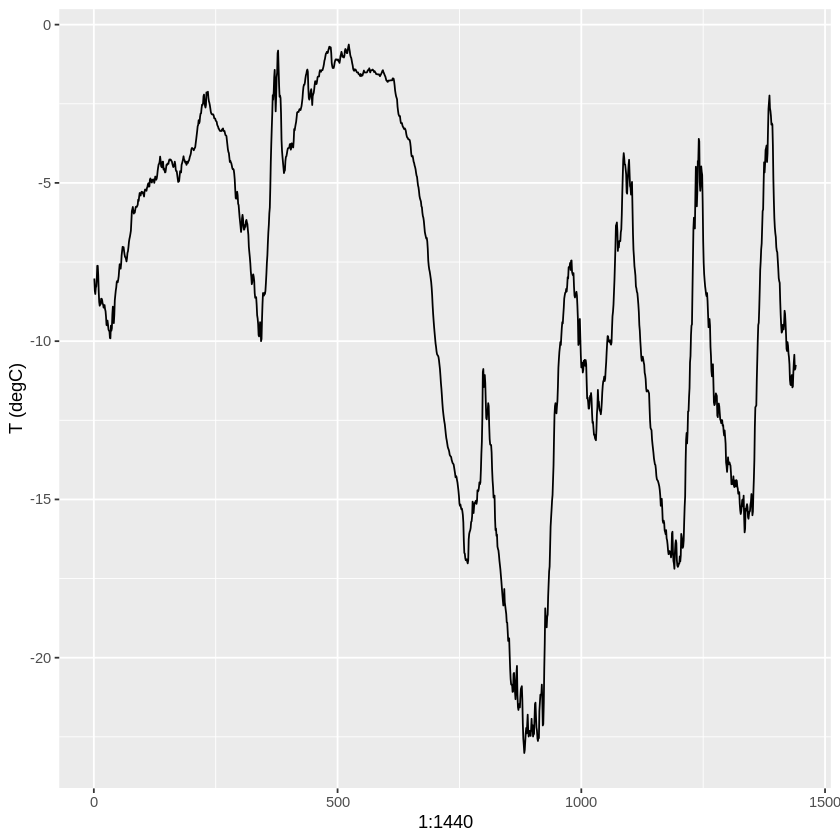

In [12]:
ggplot(data[1:1440,], aes(x = 1:1440, y = `T (degC)`)) + geom_line()

On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is this timeseries predictable at a daily scale? Let's find out.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 1440`, i.e. our observations will go back 10 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.
* Write a generator function that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample _N_ and sample _N + 1_ will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you'll generate the samples on the fly using the original data.

First, you'll convert the R data frame which we read earlier into a matrix of floating point values (we'll discard the first column which included a text timestamp):


In [13]:
data <- data.matrix(data[,-1])

You'll then preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You're going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation for normalization only on this fraction of the data.

In [14]:
train_data <- data[1:200000,]
mean <- apply(train_data, 2, mean)
std <- apply(train_data, 2, sd)
data <- scale(data, center = mean, scale = std)

Now here is the data generator you'll use. It yields a list `(samples, targets)`, where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data` -- The original array of floating-point data, which you normalized in listing 6.32.
* `lookback` -- How many timesteps back the input data should go.
* `delay` -- How many timesteps in the future the target should be.
* `min_index` and `max_index` -- Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
* `shuffle` -- Whether to shuffle the samples or draw them in chronological order.
* `batch_size` -- The number of samples per batch.
* `step` -- The period, in timesteps, at which you sample data. You'll set it 6 in order to draw one data point every hour.

In [15]:
generator <- function(data, lookback, delay, min_index, max_index,
                      shuffle = FALSE, batch_size = 128, step = 6) {
  if (is.null(max_index))
    max_index <- nrow(data) - delay - 1
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    
    samples <- array(0, dim = c(length(rows), 
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
                     
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]], 
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices,]
      targets[[j]] <- data[rows[[j]] + delay,2]
    }            
    
    list(samples, targets)
  }
}

The `i` variable contains the state that tracks next window of data to return, so it is updated using
superassignment (e.g. `i <<- i + length(rows)`).

Now, let's use the abstract `generator` function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [16]:
lookback <- 1440
step <- 6
delay <- 144
batch_size <- 128

train_gen <- generator(
  data,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = 200000,
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

val_gen = generator(
  data,
  lookback = lookback,
  delay = delay,
  min_index = 200001,
  max_index = 300000,
  step = step,
  batch_size = batch_size
)

test_gen <- generator(
  data,
  lookback = lookback,
  delay = delay,
  min_index = 300001,
  max_index = NULL,
  step = step,
  batch_size = batch_size
)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps <- (300000 - 200001 - lookback) / batch_size

  # This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps <- (nrow(data) - 300001 - lookback) / batch_size

## A basic machine learning approach

It's useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two dense layers. Note the lack of activation function on the last dense layer, which is typical for a regression problem. You use MAE as the loss. Because you're evaluating on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [18]:
install.packages('keras')
library(keras)

model <- keras_model_sequential() %>% 
  layer_flatten(input_shape = c(lookback / step, dim(data)[-1])) %>% 
  layer_dense(units = 32, activation = "relu") %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 20,
  validation_data = val_gen,
  validation_steps = val_steps
)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’



Attaching package: ‘keras’


The following object is masked from ‘package:R.utils’:

    evaluate


The following object is masked from ‘package:R.oo’:

    compile


Loaded Tensorflow version 2.8.0

Warning message in fit_generator(., train_gen, steps_per_epoch = 500, epochs = 20, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


Let's display the loss curves for validation and training:

`geom_smooth()` using formula 'y ~ x'



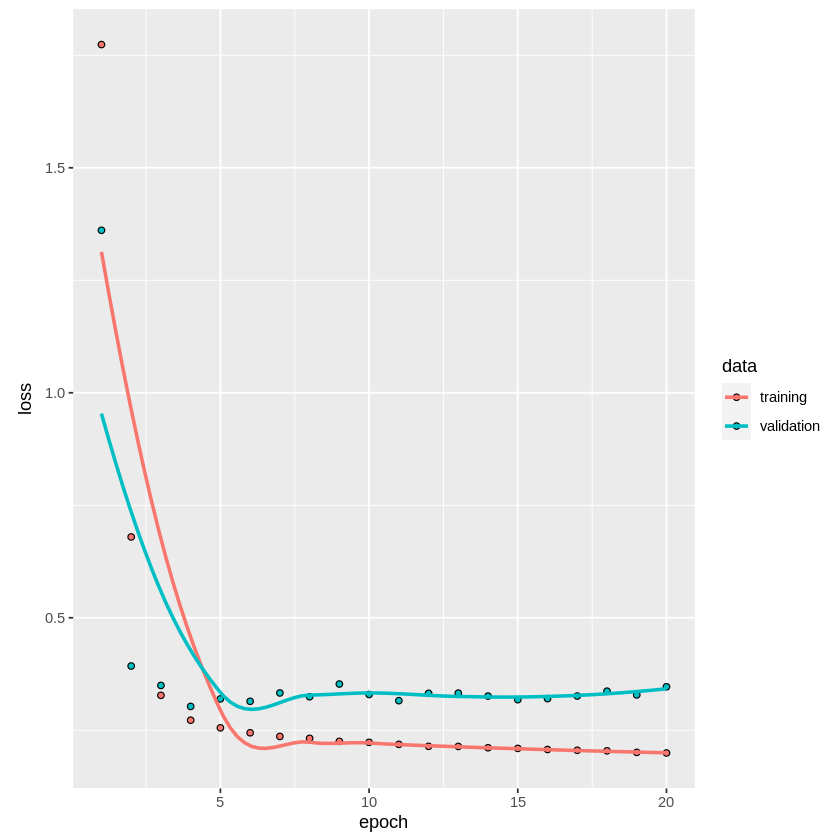

In [19]:
plot(history)

Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the LSTM layer introduced in the previous section, we will use the GRU layer, developed by Cho et al. in 2014. GRU layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [20]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 32, input_shape = list(NULL, dim(data)[[-1]])) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 20,
  validation_data = val_gen,
  validation_steps = val_steps
)

Warning message in fit_generator(., train_gen, steps_per_epoch = 500, epochs = 20, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


Let look at our results:

`geom_smooth()` using formula 'y ~ x'



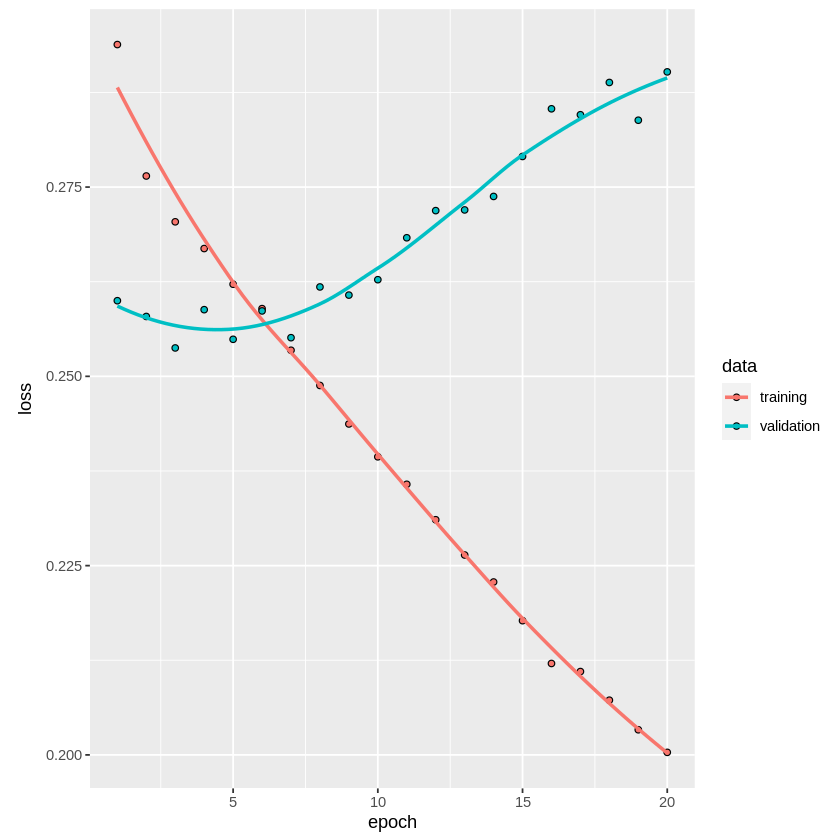

In [21]:
plot(history)

Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs. 
(PLEASE NOTE THAT THIS CAN ONLY BE REALISTICALLY RUN ON GPU SETUPS, THIS SECTION IS INCLUDED FOR PURPOSES OF REFERENCE ONLY!)

In [ ]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 32, dropout = 0.2, recurrent_dropout = 0.2,
            input_shape = list(NULL, dim(data)[[-1]])) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 40,
  validation_data = val_gen,
  validation_steps = val_steps
)

In [ ]:
plot(history)

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying `return_sequences = TRUE`: 

(PLEASE NOTE THAT AS MENTIONED ABOVE, THIS CAN ONLY BE REALISTICALLY RUN ON GPU SETUPS, THIS SECTION IS INCLUDED FOR PURPOSES OF REFERENCE ONLY!)

In [ ]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 32, 
            dropout = 0.1, 
            recurrent_dropout = 0.5,
            return_sequences = TRUE,
            input_shape = list(NULL, dim(data)[[-1]])) %>% 
  layer_gru(units = 64, activation = "relu",
            dropout = 0.1,
            recurrent_dropout = 0.5) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 40,
  validation_data = val_gen,
  validation_steps = val_steps
)

Let's take a look at our results:

In [ ]:
plot(history)

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this point.

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it's a decision we made no attempt to question so far. Could the RNNs have 
performed well enough if they processed input sequences in antichronological order, for instance (newer timesteps first)? Let's try this in practice and see what happens. All you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with `list(samples[,ncol(samples):1,], targets)`). Training the same one-GRU-layer network that you used in the first experiment in this section, you get the results shown below.

In [22]:
reverse_order_generator <- function( data, lookback, delay, min_index, max_index,
                                     shuffle = FALSE, batch_size = 128, step = 6) {
  if (is.null(max_index))
    max_index <- nrow(data) - delay - 1
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    
    samples <- array(0, dim = c(length(rows), 
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
                     
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]], 
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices,]
      targets[[j]] <- data[rows[[j]] + delay,2]
    }            
    
    list(samples[,ncol(samples):1,], targets)
  }
}

train_gen_reverse <- reverse_order_generator(
  data,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = 200000,
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

val_gen_reverse = reverse_order_generator(
  data,
  lookback = lookback,
  delay = delay,
  min_index = 200001,
  max_index = 300000,
  step = step,
  batch_size = batch_size
)

In [23]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 32, input_shape = list(NULL, dim(data)[[-1]])) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen_reverse,
  steps_per_epoch = 500,
  epochs = 20,
  validation_data = val_gen_reverse,
  validation_steps = val_steps
)

Warning message in fit_generator(., train_gen_reverse, steps_per_epoch = 500, epochs = 20, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


In [ ]:
plot(history)

So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's try the same trick on the LSTM IMDB example from the previous section:

In [ ]:
library(keras)

max_features <- 10000  # Number of words to consider as features
maxlen <- 500          # Cut texts after this number of words 
                       # (among top max_features most common words)

# Load data
imdb <- dataset_imdb(num_words = max_features)
c(c(x_train, y_train), c(x_test, y_test)) %<-% imdb

# Reverse sequences
x_train <- lapply(x_train, rev) 
x_test <- lapply(x_test, rev) 

# Pad sequences
x_train <- pad_sequences(x_train, maxlen = maxlen)
x_test <- pad_sequences(x_test, maxlen = maxlen)

model <- keras_model_sequential() %>% 
  layer_embedding(input_dim = max_features, output_dim = 128) %>% 
  layer_lstm(units = 32) %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("acc")
)
  
history <- model %>% fit(
  x_train, y_train,
  epochs = 10,
  batch_size = 128,
  validation_split = 0.2
)

We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, you use the `bidirectional()` function, which takes a recurrent layer instance as an argument. The `bidirectional()` function creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the IMDB sentiment-analysis task.

In [ ]:
k_clear_session()

In [ ]:
model <- keras_model_sequential() %>% 
  layer_embedding(input_dim = max_features, output_dim = 32) %>% 
  bidirectional(
    layer_lstm(units = 32)
  ) %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("acc")
)

history <- model %>% fit(
  x_train, y_train,
  epochs = 10,
  batch_size = 128,
  validation_split = 0.2
)

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:
(PLEASE NOTE THAT THIS CAN ONLY BE REALISTICALLY RUN ON GPU SETUPS, THIS SECTION IS INCLUDED FOR PURPOSES OF REFERENCE ONLY!)

In [ ]:
model <- keras_model_sequential() %>% 
  bidirectional(
    layer_gru(units = 32), input_shape = list(NULL, dim(data)[[-1]])
  ) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 40,
  validation_data = val_gen,
  validation_steps = val_steps
)

It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

## Going even further

There are many other things you could try, in order to improve performance on the weather-forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus probably suboptimal.
* Adjust the learning rate used by the `RMSprop` optimizer.
* Try using `layer_lstm()` instead of `layer_gru()`.
* Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger dense layer or even a stack of dense layers.
* Don't forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, you'll develop architectures that are overfitting to the validation set.   

As always, deep learning is more an art than a science. We can provide guidelines that tell you what is likely to work or not work on a given problem, but, ultimately, every problem is unique; you'll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

## Wrapping up

Here's what you should take away from this section:

* As you first learned in chapter 4, when approaching a new problem, it's good to first establish common-sense baselines for your metric of choice. If you don't have a baseline to beat, you can't tell whether you're making real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* When you have data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
* To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They're also much more expensive and thus not always worth it. 
Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are useful on natural-language processing problems. But they aren't strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

There are two important concepts we won't cover in detail here: recurrent attention and sequence masking. Both tend to be especially relevant for natural-language processing, and they aren't particularly applicable to thetemperature-forecasting problem. We'll leave them for future study outside of this book.